### This notebook shows examples of how to manipulate the clinical data and metadata. Three tasks will be accomplished:
#### 1 : Get the path of all BIRADS-1 and BIRADS-2 screening images
#### 2a : Summarize image findings and append to clinical table
#### 2b : Get all BIRADS-0 images, the cancer cases and show their ROIs


In [3]:
import pandas as pd
import numpy as np
import re
import pydicom
import pylibjpeg
import matplotlib.patches as patches
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)


Preparing the datasets, and show datasets size:

In [5]:
def stats(df): #the function displays dataframe size, countings of unique patients and unique exams
    print('Dataframe size: ' + str(df.shape))
    try:
        print('# patients: ' + str(df.empi_anon.nunique()))
    except:
        print('# patients: ' + str(df.empi_anon_x.nunique()))
    print('# exams: ' + str(df.acc_anon.nunique()))

In [6]:
#load in clinical and metadata dataframes
# basepath = "./" #define the file directory
basepath = "/opt/localdata/Data/hmtrive/mammo/AWSOpenData/" #define the file directory
#Load clinical and filter for fields needed for the tasks we are showcasing in this notebook
df_clinical = pd.read_csv(basepath + "tables/EMBED_OpenData_clinical.csv")

df_clinical = df_clinical[['empi_anon','acc_anon','study_date_anon','asses', 'tissueden',
                          'desc','side','path_severity','numfind','total_L_find','total_R_find',
                          'massshape','massmargin','massdens','calcfind','calcdistri','calcnumber',
                          'ETHNICITY_DESC','ETHNIC_GROUP_DESC','age_at_study','ETHNIC_GROUP_DESC']]
stats(df_clinical)

#Load metadata and filter for fields needed for the tasks we are showcasing in this notebook
df_metadata = pd.read_csv(basepath + "tables/EMBED_OpenData_metadata.csv")
df_metadata = df_metadata[['anon_dicom_path','empi_anon','acc_anon','study_date_anon',
                            'StudyDescription','SeriesDescription','FinalImageType',
                            'ImageLateralityFinal','ViewPosition','spot_mag','ROI_coords','num_roi']]

stats(df_metadata)

/tmp/ipykernel_2921492/1755561827.py:5: DtypeWarning: Columns (32,35,37,52,53,57,58,59,60,61,63,85,88,89,97,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clinical = pd.read_csv(basepath + "tables/EMBED_OpenData_clinical.csv")


Dataframe size: (81776, 21)
# patients: 23253
# exams: 72770


/tmp/ipykernel_2921492/1755561827.py:14: DtypeWarning: Columns (115,116,117,118,119,120,130,132,133,134,135,136,138,143,147,148,149) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metadata = pd.read_csv(basepath + "tables/EMBED_OpenData_metadata.csv")


Dataframe size: (480323, 12)
# patients: 23256
# exams: 72770


### Task 1: Get the dicom file path of all BIRADS-1 and BIRADS-2 screening 2D images

In [7]:
#filter for screening exams only
df_clinical_screen = df_clinical.loc[df_clinical.desc.str.contains('screen',case=False)]
stats(df_clinical_screen)


Dataframe size: (58888, 21)
# patients: 20460
# exams: 55956


In [8]:
# Filtering clinical data for birads 1 (negative) and 2 (benign) assessments. 
df_clinical_br12 = df_clinical_screen[(df_clinical_screen.asses == "N") | (df_clinical_screen.asses == "B")]
# The column 'asses' indicates the BIRADS assessment of the exam. 'N' indicates negative/BIRADS-1, 'B' indicates benign/BIRADS-2
stats(df_clinical_br12)

Dataframe size: (48003, 21)
# patients: 17545
# exams: 47476


In [ ]:
# Merging metadata and clinical data on exam ID (acc_anon). This will link the clinical data to the file list from metadata
df_merge12 = pd.merge(df_metadata, df_clinical_br12, on=['acc_anon'])

# The 'side' column in the clinical data represents the laterality of the finding in that row, and can be 
#L (left), R (right), B (bilateral), or NaN (when there is no finding). Therefore when merging clinical 
#and metadata, we must first match by exam ID and then match the laterality of the clinical finding (side) 
#to the laterality of the image (ImageLateralityFinal)/ Side "B" and "NaN" can be matched to 
#ImageLateralityFinal both "L" and "R"

df_merge12 = df_merge12.loc[
    (df_merge12.side == df_merge12.ImageLateralityFinal) 
    | (df_merge12.side == 'B') | (pd.isna(df_merge12.side))] 

stats(df_merge12)

In [10]:
#filter for 2D images only
df_merge12_2d = df_merge12.loc[df_merge12.FinalImageType=='2D']
stats(df_merge12_2d)

Dataframe size: (226557, 32)
# patients: 17547
# exams: 47475


In [13]:
#generate list of all files dicom paths
br12_img_list = list(df_merge12_2d.anon_dicom_path.unique())
print(len(br12_img_list))
br12_img_list[0]

225450


'./images/cohort_1/66685715/1.2.847.113975.3.62.1.55671517.20170931.1/1.2.844.113684.2750828166.1506503583.4742.253/1.2.826.0.1.3680043.8.498.12113965649920234975762962308241977870.dcm'

### Task 2a: Summarize image findings and append to clinical table

In [14]:
# Filtering clinical data for birads 0 since these cases contain abnormalities with descriptors
df_clinical_br0 = df_clinical.loc[df_clinical.asses == "A"]
stats(df_clinical_br0)

Dataframe size: (11425, 21)
# patients: 8045
# exams: 9291


In [22]:
# Adding columns "mass", "asymmetry", "arch_distortion" and "calc" as a summary of imaging findings contained in the 
#other columns. This will be coded as 1 = present; 0 = absent

df_findings_count = df_clinical_br0.copy()
df_findings_count = df_findings_count.reset_index(drop=True)

# Instantiate lists for the four finding type -  mass, asymmetry, architectural distortion and calcification
# Default value set to 0. 
mass_list = [0]*df_findings_count.shape[0]
asymmetry_list = [0]*df_findings_count.shape[0]
arch_destortion_list = [0]*df_findings_count.shape[0]
calc_list = [0]*df_findings_count.shape[0]


# Architectural Distortion is defined as: 'massshape' ['Q', 'A']
# Asymmetry is defined as: 'massshape' in ['T', 'B', 'S', 'F', 'V']
# Mass is defined as: 'massshape' in ['G', 'R', 'O', 'X', 'N', 'Y', 'D', 'L']
#       or 'massmargin' in ['D', 'U', 'M', 'I', 'S']
#       or 'massdens' in ['+', '-', '=']
# Calcification: defined as presence of any non-zero or non-null value in "calcdistri", "calcfind" or "calcnumber"

#iterate through rows and assign values to the lists based on above rules
for ind, row in df_findings_count.iterrows():
    if (row['massshape'] in ['G', 'R', 'O', 'X', 'N', 'Y', 'D', 'L']) or (row['massmargin'] in ['D', 'U', 'M', 'I', 'S']) or (row['massdens'] in ['+', '-', '=']):
        mass_list[ind] = 1
        
    if row['massshape'] in ['T', 'B', 'S', 'F', 'V']:
        asymmetry_list[ind] = 1

    if row['massshape']in ['Q', 'A']:
        arch_destortion_list[ind] = 1
        
    if (row['calcdistri'] is not np.nan) or (row['calcfind'] is not np.nan) or (row['calcnumber'] != 0):
        calc_list[ind] = 1        

# Append the final image findings columns to the dataframe        
df_findings_count['mass'] = mass_list
df_findings_count['asymmetry'] = asymmetry_list
df_findings_count['arch_distortion'] = arch_destortion_list
df_findings_count['calc'] = calc_list

df_findings_count.sample(3)

,empi_anon,acc_anon,study_date_anon,asses,tissueden,desc,side,path_severity,numfind,total_L_find,total_R_find,massshape,massmargin,massdens,calcfind,calcdistri,calcnumber,ETHNICITY_DESC,ETHNIC_GROUP_DESC,age_at_study,ETHNIC_GROUP_DESC,mass,asymmetry,arch_distortion,calc
2963,76880050,4932273561626049,2017-04-19,A,2.0,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R,NaN,1,1.0,1.0,S,NaN,NaN,NaN,NaN,0,Caucasian or White,Non-Hispanic or Latino,52.031185,Non-Hispanic or Latino,0,1,0,0
7207,72624209,5538439865589975,2015-02-22,A,3.0,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,NaN,2,2.0,0.0,NaN,NaN,NaN,NaN,NaN,0,African American or Black,Non-Hispanic or Latino,54.936104,Non-Hispanic or Latino,0,0,0,0
812,87483882,2893568225625407,2015-01-10,A,2.0,MG Screening Bilateral,R,NaN,1,0.0,2.0,X,I,=,NaN,NaN,0,Caucasian or White,Non-Hispanic or Latino,70.514795,Non-Hispanic or Latino,1,0,0,0


In [23]:
print('Mass findings count')
print(df_findings_count.mass.value_counts(),'\n')
print('Asymmetry findings count')
print(df_findings_count.asymmetry.value_counts(),'\n')
print('Architectural distortion findings count')
print(df_findings_count.arch_distortion.value_counts(),'\n')
print('Calcification findings count')
print(df_findings_count.calc.value_counts())

Mass findings count
0    9801
1    1624
Name: mass, dtype: int64 

Asymmetry findings count
1    5752
0    5673
Name: asymmetry, dtype: int64 

Architectural distortion findings count
0    10854
1      571
Name: arch_distortion, dtype: int64 

Calcification findings count
0    9492
1    1933
Name: calc, dtype: int64


In [24]:
df_clinical_br0_addFindings = df_findings_count.copy()

### Task 2b: Get all BIRADS-0 images, the cancer cases where there're ROIs, export as table

In [31]:
# Merging metadata and updated clinical data using the exam ID. This will merge ALL rows with a given acc_anon from
# the clinical data with ALL rows containing files from that exam in the metadata
df_merge0 = pd.merge(df_metadata, df_clinical_br0_addFindings, on=['acc_anon'])
stats(df_merge0)

# The 'side' column in the clinical data represents the laterality of the finding in that row, and can be L (left), 
# R (right), B (bilateral), or NaN (when there is no finding). Therefore when merging clinical and metadata, we must 
# first match by exam ID and then match the laterality of the clinical finding (side) to the laterality of the image 
# (ImageLateralityFinal). Side "B" and "NaN" can be matched to ImageLateralityFinal both "L" and "R"
df_merge0 = df_merge0.loc[
    (df_merge0.side == df_merge0.ImageLateralityFinal) 
    | (df_merge0.side == 'B') | (pd.isna(df_merge0.side))] 

df_merge0.drop_duplicates(inplace=True)
stats(df_merge0) 
#Note the significant drop in number of rows after forcing the above laterality match while maintaining the number 
# of patients and exams. A few exams/patients are lost if there is no image to match the side of the finding, which
# may be due to data entry error or data loss during extraction

Dataframe size: (77526, 36)
# patients: 8045
# exams: 9291
Dataframe size: (42511, 36)
# patients: 8042
# exams: 9287


In [34]:
#Filter for 2D and C-view images only. Currently the EMBED AWS Open dataset does not contain any other image types,
# but we retain this code for future use when it will contain DBT, MRI, and US
df_merge0_2d_cview = df_merge0.loc[df_merge0.FinalImageType.isin(['2D','cview'])]
stats(df_merge0_2d_cview)

Dataframe size: (42511, 36)
# patients: 8042
# exams: 9287


In [38]:
# Filtering cancer cases. When "path_severity" is 0 (invasive breast cancer) or 1 (in situ cancer). 
# path_severity 2-5 indicates benign and NaN means never biopsied.
df_cancer = df_merge0_2d_cview[df_merge0_2d_cview['path_severity'].isin([0,1])]

stats(df_cancer)
#the resultant dataframe has one row per IMAGE containing cancer since clinical data and metadata are already merged.
#Note that the number of patients and exams is lower since there are multiple images per patient

Dataframe size: (1208, 36)
# patients: 273
# exams: 279


In [37]:
#we will now get the list of ROIs for each of these images. ROIs are structured as a list of lists, and each image
# can have 0 to multiple ROIs. We will therefore parse the ROI list to expand it such that each row will contain one ROI.
# If an image has multiple ROIs, this will result in multiple rows for that image in the resultant dataframe

#define function
def separate_roi(df):
    df_list = []
    for ind, row in df.iterrows():
        path = row['anon_dicom_path']
        roi_num = [int(s) for s in re.findall(r'\b\d+\b', row['ROI_coords'])]
        if len(roi_num)==4:
            df_list.append([path, row['ROI_coords'], row['ROI_coords']])
        else:
            count = 0
            roi = []
            for i in roi_num:
                count += 1
                roi.append(i)
                if count%4 == 0:
                    df_list.append([path, row['ROI_coords'], "(("+str(roi[0])+", "+str(roi[1])+", "+str(roi[2])+", "+str(roi[3])+"),)"])
                    roi = []
    df_roi_sep = pd.DataFrame(df_list)
    df_roi_sep.columns = ['anon_dicom_path','ROI_coords','ROI_separated']
    df_cp = df.copy()
    df_cp = df_cp.merge(df_roi_sep, how='left', on=['anon_dicom_path','ROI_coords'])
    return df_cp

In [40]:
# To export ROIs, filter the ones with ROIs
df_cancer_ROI = df_cancer.loc[df_cancer.ROI_coords!='()']
stats(df_cancer_ROI)

# Separate multiple ROIs into individual rows
df_cancer_ROI = separate_roi(df_cancer_ROI)
stats(df_cancer_ROI)

# Export to csv
df_cancer_ROI.to_csv("BR0CancerROIs.csv")

Dataframe size: (271, 36)
# patients: 83
# exams: 83
Dataframe size: (413, 37)
# patients: 83
# exams: 83


Showing an example ROI

In [41]:
df_cancer_ROI.ROI_coords

0                              ((1365, 272, 1610, 508),)
1                              ((1951, 347, 2244, 626),)
2                             ((2300, 776, 2689, 1149),)
3                             ((2053, 809, 2295, 1054),)
4                              ((1514, 704, 1681, 976),)
5                              ((2181, 597, 2328, 844),)
6                            ((2326, 1057, 2892, 1591),)
7                             ((1328, 339, 1960, 1051),)
8       ((992, 202, 1276, 647), (2098, 302, 2647, 1089))
9       ((992, 202, 1276, 647), (2098, 302, 2647, 1089))
10      ((1079, 654, 1358, 914), (2357, 269, 3101, 946))
11      ((1079, 654, 1358, 914), (2357, 269, 3101, 946))
12                           ((2202, 1399, 2455, 1775),)
13                            ((1321, 839, 1473, 1064),)
14                           ((2690, 1354, 3076, 1680),)
15                            ((1614, 812, 1845, 1007),)
16                               ((1057, 1, 1432, 225),)
17          ((780, 1, 1057, 166

In [42]:
sample_file_name = df_cancer_ROI.anon_dicom_path[1]
sample_file_ROI = df_cancer_ROI.ROI_coords[1]
sample_file_ROI

'((1951, 347, 2244, 626),)'

In [43]:
sample_file_name

'./images/cohort_1/18939478/1.2.849.113974.3.61.1.52711867.20160329.1091560/1.2.848.113681.2230564627.935.3636186671.120.1/1.2.826.0.1.3680043.8.498.12257306895206838611171994903114978464.dcm'

In [6]:
# Read in sample dicom file
ds = pydicom.dcmread(sample_file_name)
arr = ds.pixel_array

# Flip the dicom file left to right, the flipping logic is included in the dcm to png file conversion code
new_np_array = np.copy(arr)
#define the width(w) and height(h) of the image
h, w = arr.shape
#make the image left-right
for j in range(0,w):
    for i in range(0,h):
        new_np_array[i,j] = arr[i,w-1-j]

In [7]:
# Getting the coordinates of ROI
rois = [int(s) for s in re.findall(r'\b\d+\b', sample_file_ROI)]
y1, x1, y2, x2 = rois

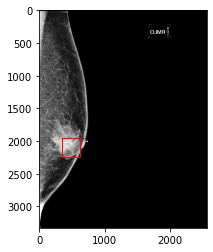

In [8]:
# Display ROI on image
figure, ax = plt.subplots(1)
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
ax.imshow(new_np_array, cmap="gray")
ax.add_patch(rect)

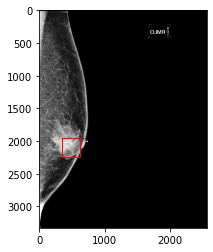

In [8]:
# Display ROI on image
figure, ax = plt.subplots(1)
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
ax.imshow(new_np_array, cmap="gray")
ax.add_patch(rect)

In [1]:
pwd

'/opt/localdata/Data/hmtrive/mammo/AWSOpenData/notebooks'

<br><br><br><br>End of notebook <br><br><br><br>